In [2]:
pip install Faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# =====================
# 1️⃣ Imports
# =====================
from faker import Faker
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 2️⃣ Setup
# =====================
fake = Faker()
Faker.seed(42)
random.seed(42)
np.random.seed(42)

# Directory setup
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [5]:
# 3️⃣ Generate Synthetic Medical Records
# =====================

def make_record():
    age = int(np.clip(np.random.normal(50, 18), 1, 100))
    gender = random.choice(["Male", "Female"])
    
    systolic_bp = round(np.clip(np.random.normal(120 + (age-50)*0.4, 12), 80, 200), 1)
    cholesterol = round(np.clip(np.random.normal(180 + (age-50)*0.6, 25), 100, 350), 1)
    glucose = round(np.clip(np.random.normal(100 + (age-50)*0.5, 18), 60, 300), 1)
    heart_rate = round(np.clip(np.random.normal(72, 10), 40, 150), 1)
    bmi = round(np.clip(np.random.normal(26, 4.5), 12, 50), 1)
    
    has_diabetes = 1 if glucose > 126 or (age > 55 and random.random() < 0.12) else 0
    smoker = 1 if random.random() < 0.18 else 0

    diag_scores = {
        "Hypertension": max(0, (systolic_bp - 130) / 40),
        "Diabetes": max(0, (glucose - 126) / 50) + 0.5*has_diabetes,
        "Heart Disease": max(0, (cholesterol - 200) / 80) + 0.5*(smoker) + 0.02*(age-50),
        "Healthy": 1.0
    }

    for k in diag_scores:
        diag_scores[k] += np.random.normal(0, 0.15)
    
    diagnosis = max(diag_scores, key=diag_scores.get)
    if random.random() < 0.06:
        diagnosis = random.choice(["Healthy","Hypertension","Diabetes","Heart Disease"])

    return {
        "Patient_ID": fake.uuid4(),
        "Name": fake.name(),
        "Age": age,
        "Gender": gender,
        "Blood_Pressure": systolic_bp,
        "Cholesterol": cholesterol,
        "Glucose": glucose,
        "Heart_Rate": heart_rate,
        "BMI": bmi,
        "Has_Diabetes": has_diabetes,
        "Smoker": smoker,
        "Diagnosis": diagnosis
    }

records = [make_record() for _ in range(10000)]
df = pd.DataFrame(records)
df.to_csv("data/synthetic_medical_records.csv", index=False)
print(f" Generated {len(df)} synthetic medical records")

 Generated 10000 synthetic medical records


In [6]:
df.head()


Patient_ID                 Name  Age  Gender  \
0  bdd640fb-0667-4ad1-9c80-317fa3b1799d         Daniel Doyle   58    Male   
1  8b9d2434-e465-4150-bd9c-66b3ad3c2d6d       Javier Johnson   41    Male   
2  9a1de644-815e-46d1-bb8f-aa1837f8a88b      Cristian Santos   76    Male   
3  72ff5d2a-386e-4be0-ab65-a6a48b8148f6         Rhonda Smith   39    Male   
4  6c307511-b2b9-437a-a8df-6ec4ce4a2bbd  Christopher Bernard   63  Female   

   Blood_Pressure  Cholesterol  Glucose  Heart_Rate   BMI  Has_Diabetes  \
0           121.5        201.0    131.4        69.7  24.9             1   
1           110.8        180.6     61.1        54.8  23.5             0   
2           127.7        197.3     87.4        66.6  26.5             0   
3           137.8        173.1     75.5        80.2  20.5             0   
4           127.3        184.9    101.1        57.2  22.8             0   

   Smoker     Diagnosis  
0       1       Healthy  
1       1       Healthy  
2       1       Healthy  
3       0  Hypertension  
4       0       Healthy

In [7]:
df.tail()

Patient_ID            Name  Age  Gender  \
9995  4ebc8ad0-a333-49b6-b6cc-c31dc6c4b384  Katherine Gray   62  Female   
9996  942ced96-5019-4a23-9307-1f0e9fff5442     April Gross   74    Male   
9997  d258eb33-902d-4f0d-9df3-b6e5a175fdb6      Mark Adams   50    Male   
9998  b612b36a-feba-4384-a97e-bc2ebec027f7     Jason Lopez   66    Male   
9999  2c12d424-06d0-4f5c-89c7-f74f5553d222  Billy Martinez   61    Male   

      Blood_Pressure  Cholesterol  Glucose  Heart_Rate   BMI  Has_Diabetes  \
9995           117.2        188.5     84.8        74.6  18.8             0   
9996           134.5        180.5    136.0        77.5  28.2             1   
9997           107.4        187.1    113.6        71.2  27.6             0   
9998           115.8        176.1    132.8        85.4  28.0             1   
9999           134.3        181.3    109.4        85.2  25.0             0   

      Smoker Diagnosis  
9995       0   Healthy  
9996       0   Healthy  
9997       0   Healthy  
9998       0   Healthy  
9999       0   Healthy

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_ID      10000 non-null  object 
 1   Name            10000 non-null  object 
 2   Age             10000 non-null  int64  
 3   Gender          10000 non-null  object 
 4   Blood_Pressure  10000 non-null  float64
 5   Cholesterol     10000 non-null  float64
 6   Glucose         10000 non-null  float64
 7   Heart_Rate      10000 non-null  float64
 8   BMI             10000 non-null  float64
 9   Has_Diabetes    10000 non-null  int64  
 10  Smoker          10000 non-null  int64  
 11  Diagnosis       10000 non-null  object 
dtypes: float64(5), int64(3), object(4)
memory usage: 937.6+ KB


In [9]:
df.describe()

Age  Blood_Pressure   Cholesterol       Glucose    Heart_Rate  \
count  10000.000000    10000.000000  10000.000000  10000.000000  10000.000000   
mean      49.560500      119.809910    179.538450     99.831140     72.126480   
std       18.255133       14.060241     27.282813     19.565584      9.974773   
min        1.000000       80.000000    100.000000     60.000000     40.000000   
25%       37.000000      110.200000    160.800000     86.200000     65.400000   
50%       50.000000      119.700000    179.400000     99.800000     72.100000   
75%       62.000000      129.200000    198.000000    113.100000     78.900000   
max      100.000000      175.300000    275.100000    180.600000    107.900000   

               BMI  Has_Diabetes        Smoker  
count  10000.00000  10000.000000  10000.000000  
mean      26.01275      0.127700      0.188900  
std        4.50416      0.333772      0.391449  
min       12.00000      0.000000      0.000000  
25%       23.00000      0.000000      0.000000  
50%       26.00000      0.000000      0.000000  
75%       29.00000      0.000000      0.000000  
max       43.70000      1.000000      1.000000

/var/folders/9j/vwmblyhj34zfcjfmsht9bjrm0000gn/T/ipykernel_3112/1822842080.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Diagnosis", data=df, palette="Set2")


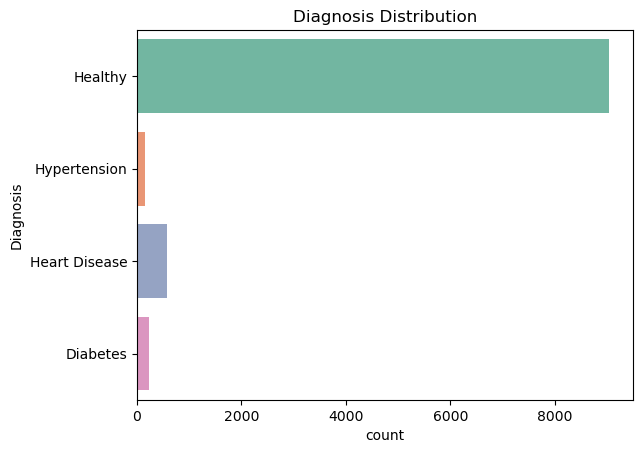

In [10]:
sns.countplot(y="Diagnosis", data=df, palette="Set2")
plt.title("Diagnosis Distribution")
plt.show()


In [12]:
# Step 1: Install the profiling library (only once)
!pip install ydata-profiling --quiet

# Step 2: Import libraries
import pandas as pd
from ydata_profiling import ProfileReport

# Step 3: Load dataset
df = pd.read_csv("data/synthetic_medical_records.csv")

# Step 4: Generate the profiling report
profile = ProfileReport(
    df,
    title="Synthetic Medical Records Profiling Report",
    explorative=True
)

# Step 5: Display the report inside Jupyter Notebook
profile.to_notebook_iframe()

# Optional Step 6: Export as an HTML file for later use or sharing
profile.to_file("medical_records_profile_report.html")

print(" Data profiling completed and report saved as 'medical_records_profile_report.html'")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 1901.46it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

 Data profiling completed and report saved as 'medical_records_profile_report.html'


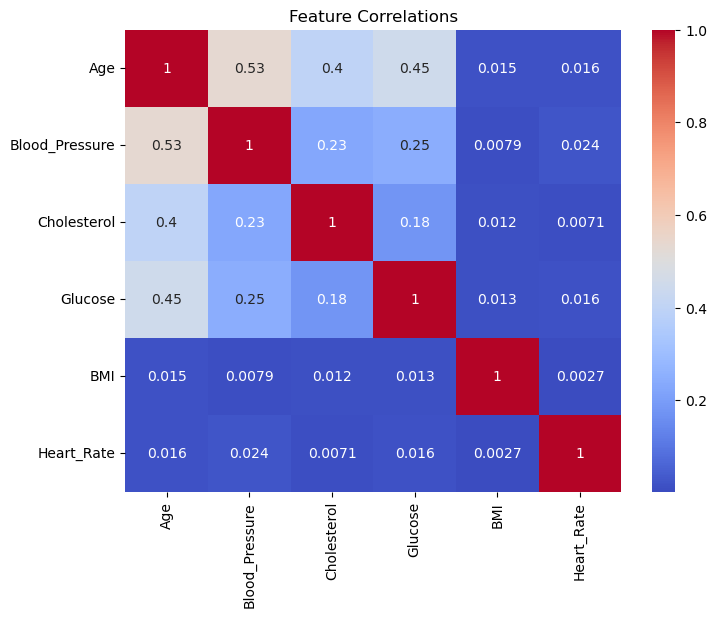

In [13]:
# Correlation heatmap
num_cols = ["Age","Blood_Pressure","Cholesterol","Glucose","BMI","Heart_Rate"]
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()


In [14]:
FEATURES = ["Age", "Blood_Pressure", "Cholesterol", "Glucose", "BMI", "Heart_Rate"]

X = df[FEATURES].values
y = df["Diagnosis"].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)

print("✅ Model trained successfully!")
print("Accuracy:", round(acc, 4))
print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=le.classes_))


✅ Model trained successfully!
Accuracy: 0.9185

Classification Report:
               precision    recall  f1-score   support

     Diabetes       0.38      0.11      0.17        46
      Healthy       0.92      0.99      0.96      1808
Heart Disease       0.83      0.29      0.43       117
 Hypertension       0.00      0.00      0.00        29

     accuracy                           0.92      2000
    macro avg       0.53      0.35      0.39      2000
 weighted avg       0.89      0.92      0.90      2000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


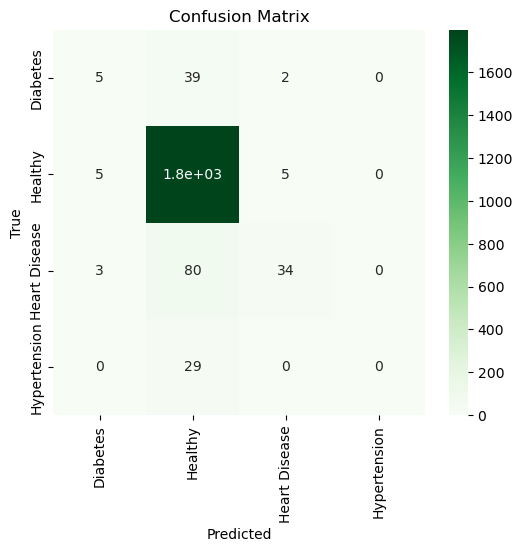

In [15]:
# Confusion matrix visualization
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [16]:
sample = np.array([[45, 135, 210, 140, 28, 78]])  # Age, BP, Cholesterol, Glucose, BMI, HeartRate
pred_idx = clf.predict(sample)[0]
pred_label = le.inverse_transform([pred_idx])[0]

proba = clf.predict_proba(sample)[0]
prob_dict = dict(zip(le.classes_, np.round(proba, 3)))

print("🩺 Input:", sample.tolist())
print("Predicted Diagnosis:", pred_label)
print("Probabilities:", prob_dict)


🩺 Input: [[45, 135, 210, 140, 28, 78]]
Predicted Diagnosis: Healthy
Probabilities: {'Diabetes': 0.093, 'Healthy': 0.814, 'Heart Disease': 0.086, 'Hypertension': 0.007}
